In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
grid_size = 5
initial_state = np.array([0,0])
loc_a = np.array([0,1])
loc_a_ = np.array([4,1])
rew_a = 10
loc_b = np.array([0,3])
loc_b_ = np.array([2,3])
rew_b = 5

In [25]:
def next_state(state, action):
    if state[0] == loc_a[0] and state[1] == loc_a[1]:
                    return loc_a_, rew_a
    elif state[0] == loc_b[0] and state[1] == loc_b[1]:
                    return loc_b_, rew_b
    else:
        if action == 0: # North
            if state[0] == 0:
                return state.astype(int), -1
            else:
                state = state + np.array([-1,0])
                return state.astype(int), 0
        if action == 1: #South
            if state[0] == grid_size - 1:
                return state.astype(int), -1
            else:
                state = state + np.array([1,0])
                return state.astype(int), 0
        if action == 2: #West
            if state[1] == 0:
                return state.astype(int), -1
            else:
                state = state + np.array([0,-1])
                return state.astype(int), 0
        if action == 3: #East
            if state[1] == grid_size -1 :
                return state.astype(int), -1
            else:
                state = state + np.array([0,1])
                return state.astype(int), 0
            

In [26]:
gamma = 0.9
max_steps = 50   # Max steps per episode


In [27]:
def epsilon_greedy_policy(state, Q, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice([0,1,2,3]) 
    else:
        x_val = int(state[0])
        y_val = int(state[1])
        best_actions = np.where(Q[x_val,y_val,:] == np.max(Q[x_val,y_val,:]))[0]
        return np.random.choice(best_actions)    # Exploit

In [38]:
def mc_off_policy(episodes, len_episode, importance_sampling = True):
    grid_size = 5
    n_actions = 4
    
    Q = np.zeros((grid_size, grid_size, n_actions))
    C = np.zeros((grid_size, grid_size, n_actions))

    target_policy = 1/n_actions * np.ones((grid_size, grid_size, n_actions))

    total_rewards = np.zeros(episodes)

    #Monte-Carlo Prediction
    for episode in range(episodes):

        state = np.array([2,2])
        rewards = np.zeros(len_episode + 1)
        states = np.zeros((len_episode + 1, 2))
        states[0, :] = state #Save the initial state
        actions = []


        for iter in range(len_episode):
            current_action = epsilon_greedy_policy(state, Q, 1)
            new_state, reward = next_state(state, current_action) # reward of this behavior policy not of interest

            state = new_state
            states[iter+1, :] = state

            if current_action == 'N': 
                current_action = 0
            elif current_action == 'S': 
                current_action = 1
            elif current_action == 'W': 
                current_action = 2
            elif current_action == 'E': 
                current_action = 3
            rewards[iter+1] = reward
            actions.append(current_action)
            

        G = 0
        W = 1
        total_rewards[episode] = np.sum(rewards)

        for t in range(len_episode , 0, -1):
            
            current_state_x = int(states[t-1, 0])
            current_state_y = int(states[t-1, 1])

            G = G * gamma + rewards[t] 
            if importance_sampling == True:
                C[current_state_x, current_state_y, actions[t-1]] += W
                Q[current_state_x, current_state_y, actions[t-1]] += (W / C[current_state_x, current_state_y, actions[t-1]]) * (G - Q[current_state_x, current_state_y, actions[t-1]])
            else:
                Q[current_state_x, current_state_y, actions[t-1]] += (G - Q[current_state_x, current_state_y, actions[t-1]])
                
            best_actions = np.where(Q[current_state_x, current_state_y, :] == np.max(Q[current_state_x, current_state_y, :]))[0]
            
            target_policy[current_state_x, current_state_y, :] = 0
            target_policy[current_state_x, current_state_y, best_actions] = 1/(1/len(best_actions))

            W *= (1/(n_actions))
        

        rewards_target = np.zeros(len_episode + 1)

        # reward of target 
        state = np.array([2,2])
        for i in range(len_episode):
            current_action = np.argmax(target_policy[state[0],state[1], :])
            new_state, reward = next_state(state, current_action) # reward of this behavior policy not of interest

            state = new_state
            rewards_target[i+1] = reward
        total_rewards[episode] = np.sum(rewards_target)

    return target_policy, Q, total_rewards


In [39]:
def visualize_action_value_with_numbers(Q):
    Q = np.round(Q, 2)
    n_rows, n_cols, n_dirs = Q.shape

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)

    for i in range(n_rows):
        for j in range(n_cols):
            ax.text(j, i - 0.2, f"{Q[i, j, 0]}", ha='center', va='center', fontsize=8, color="red")  # North
            ax.text(j, i + 0.2, f"{Q[i, j, 1]}", ha='center', va='center', fontsize=8, color="green")  # South
            ax.text(j - 0.2, i, f"{Q[i, j, 2]}", ha='center', va='center', fontsize=8, color="blue")  # West
            ax.text(j + 0.2, i, f"{Q[i, j, 3]}", ha='center', va='center', fontsize=8, color="orange")  # East

    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Action Value Visualization")
    plt.show()

In [40]:
def visualize_policy(policy):
    n_rows, n_cols, n_dirs = policy.shape

    fig, ax = plt.subplots(figsize=(n_cols, n_rows))
    ax.set_xlim(-0.5, n_cols - 0.5)
    ax.set_ylim(-0.5, n_rows - 0.5)
    ax.set_xticks(np.arange(-0.5, n_cols, 1))
    ax.set_yticks(np.arange(-0.5, n_rows, 1))
    ax.grid(True)
    
    # Arrow parameters
    arrow_params = {
        "head_width": 0.2,
        "head_length": 0.2,
        "length_includes_head": True,
        "color": "blue",
    }
    
    for i in range(n_rows):
        for j in range(n_cols):
            # Check each direction
            if policy[i, j, 0] > 0:  # North
                ax.arrow(j, i, 0, -0.4, **arrow_params)
            if policy[i, j, 1] > 0:  # South
                ax.arrow(j, i, 0, 0.4, **arrow_params)
            if policy[i, j, 2] > 0:  # West
                ax.arrow(j, i, -0.4, 0, **arrow_params)
            if policy[i, j, 3] > 0:  # East
                ax.arrow(j, i, 0.4, 0, **arrow_params)
    
    # Reverse the y-axis to align with matrix indexing
    ax.invert_yaxis()
    plt.title("Policy Visualization")
    plt.show()


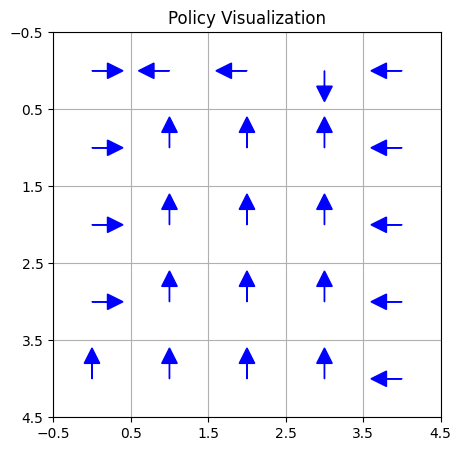

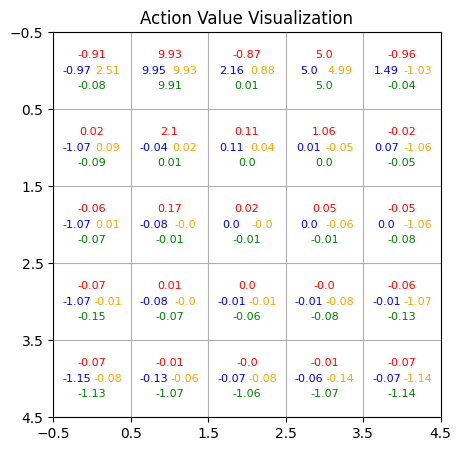

In [31]:
episodes = 10000
len_epsiode = 50
target_policy, Q, total_target_rewards = mc_off_policy(episodes, len_epsiode)
visualize_policy(target_policy)
visualize_action_value_with_numbers(Q)

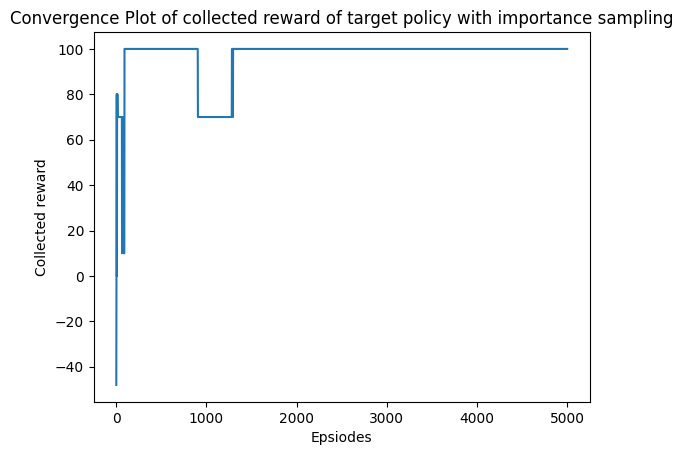

In [41]:
x_vals = np.arange(episodes)
plt.xlabel('Epsiodes')
plt.ylabel('Collected reward')
plt.title('Convergence Plot of collected reward of target policy with importance sampling')
plt.plot(x_vals[:5000],total_target_rewards[:5000])
plt.show()

Without importance sampling -> doenst look good (no convergence)

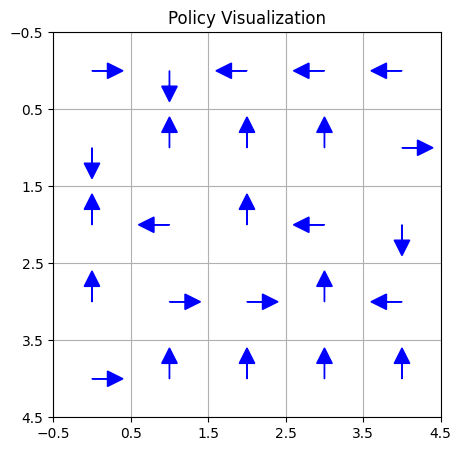

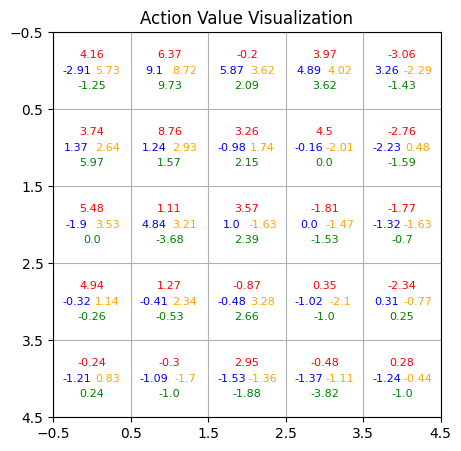

In [44]:
target_policy, Q, total_target_rewards_without_importance = mc_off_policy(20000, len_epsiode, importance_sampling=False)
visualize_policy(target_policy)
visualize_action_value_with_numbers(Q)

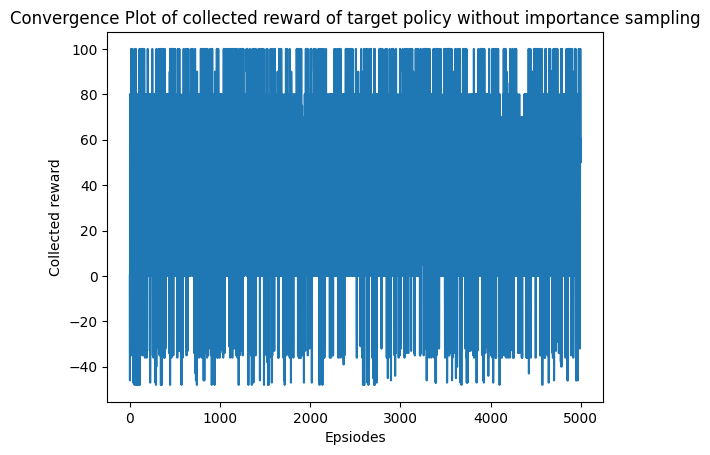

In [46]:
x_vals = np.arange(episodes)
plt.xlabel('Epsiodes')
plt.ylabel('Collected reward')
plt.title('Convergence Plot of collected reward of target policy without importance sampling')
plt.plot(x_vals[:5000],total_target_rewards_without_importance[:5000])
plt.show()

# b)
Dont know why this doesnt converge to a good final policy ...

In [35]:
def sarsa_on_policy_td_n(alpha, gamma, epsilon, episodes, len_epsiode,n):

    grid_size = 5
    n_actions = 4
    
    Q = np.zeros((grid_size, grid_size, n_actions))

    for episode in range(episodes):
        state = np.array([2,2])
        action = epsilon_greedy_policy(state, Q , epsilon)
        
        for _ in range(len_epsiode):

            next_states = np.zeros((n+1,2), dtype= int)
            next_actions = np.zeros(n+1, dtype= int)
            next_rewards = np.zeros(n+1)
            next_states[0] = state
            next_actions[0] = action
            for step in range(n):
                next_states[step+1], next_rewards[step+1] = next_state(next_states[step], next_actions[step])
                next_actions[step+1] = epsilon_greedy_policy(next_states[step+1],Q,epsilon)
            gammas = np.array([gamma**i for i in range(n)])
            x_val = int(next_states[n][0])
            y_val = int(next_states[n][1])
            G =  np.dot(next_rewards[1:],gammas) + gamma**n * Q[x_val, y_val,next_actions[n]]
            Q[state[0],state[1],action] += alpha *(G - Q[state[0],state[1], action])

            # Transition to the next state
            state = next_states[1]
            action = next_actions[1]
            
    
    return Q

In [47]:
alpha = 0.1
gamma = 0.9
epsilon = 0.1
max_steps = 50
episodes = 50000
n = 1

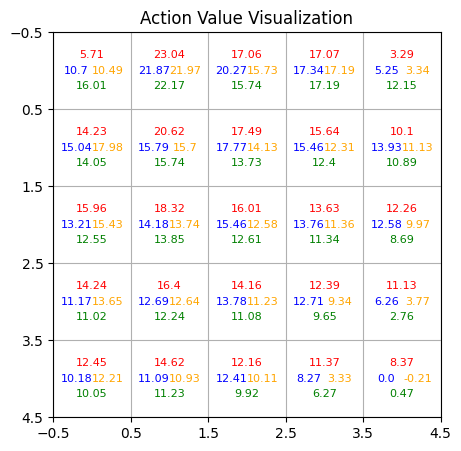

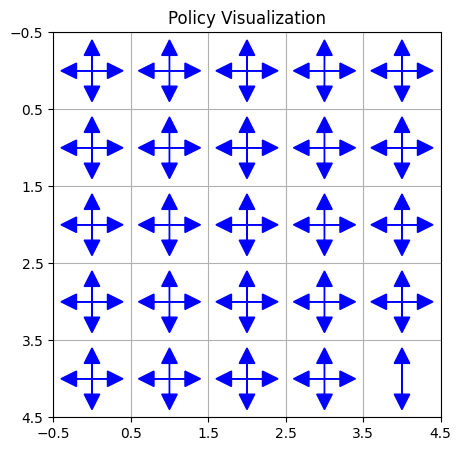

In [48]:
sarsa_q =sarsa_on_policy_td_n(alpha,gamma,epsilon,episodes,max_steps,n)
visualize_action_value_with_numbers(sarsa_q)
visualize_policy(sarsa_q)